In [1]:
import json
from datasets import Dataset, DatasetDict

# 读取JSON数据文件
with open('/home/pp/LE-dataset v2.1-150-topic-openchat- v1.2.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# 提取拉丁短语、对应的英文句子和主题标签
latin_phrases = [entry["local sentence"] for entry in data]
english_sentences = [entry["llmed reponse"] for entry in data]
topics = [entry["topic"] for entry in data]

# 创建字典
data_dict = {
    "latin_phrase": latin_phrases,
    "english_sentence": english_sentences,
    "topic": topics
}

# 创建Hugging Face的Dataset对象
dataset = Dataset.from_dict(data_dict)

# 如果需要，可以创建DatasetDict对象
dataset_dict = DatasetDict({"train": dataset})

# 保存为Hugging Face的dataset格式
dataset.save_to_disk("latin_english_dataset_with_topics")

print("数据集已保存到 latin_english_dataset_with_topics 目录")


Saving the dataset (0/1 shards):   0%|          | 0/16332 [00:00<?, ? examples/s]

数据集已保存到 latin_english_dataset_with_topics 目录


In [2]:
from datasets import load_from_disk

dataset = load_from_disk("latin_english_dataset_with_topics")
print(dataset)

Dataset({
    features: ['latin_phrase', 'english_sentence', 'topic'],
    num_rows: 16332
})


In [4]:
dataset['latin_phrase'][0]

'But I’m not convinced.\nI wrote a pros and cons piece last year on aero kits. Given what I like about IndyCar and what I believe the series needs, the cons outweigh the pros.'

In [3]:
import os
os.environ['http_proxy'] = 'http://127.0.0.1:7890'
os.environ['https_proxy'] = 'http://127.0.0.1:7890'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

!curl google.com

<HTML><HEAD><meta http-equiv="content-type" content="text/html;charset=utf-8">
<TITLE>301 Moved</TITLE></HEAD><BODY>
<H1>301 Moved</H1>
The document has moved
<A HREF="http://www.google.com/">here</A>.
</BODY></HTML>


In [5]:
import torch
from transformers import BertTokenizer, BertModel
from datasets import load_from_disk
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from tqdm import tqdm
import matplotlib.pyplot as plt

# 检查是否有可用的GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 加载数据集
dataset = load_from_disk("latin_english_dataset_with_topics")
print(dataset)

# 采样1万个样本
sample_size = 10000
sampled_dataset = dataset.shuffle(seed=42).select(range(sample_size))

# 提取拉丁短语和英文句子的特征向量
latin_texts = sampled_dataset["latin_phrase"]
english_texts = sampled_dataset["english_sentence"]

# 初始化模型和分词器
model_name = "/home/pp/.cache/huggingface/hub/models--bert-base-multilingual-cased/snapshots/3f076fdb1ab68d5b2880cb87a0886f315b8146f8"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name, output_hidden_states=True).to(device)

def extract_features(texts, batch_size=32):
    all_features = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Extracting features"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        # 提取所有层的hidden states，从第1层到第12层
        hidden_states = outputs.hidden_states
        for j in range(len(batch_texts)):
            features = [hidden_states[layer][j, 0, :].cpu().numpy() for layer in range(1, len(hidden_states))]
            all_features.append(features)
    return all_features

latin_features = extract_features(latin_texts)
english_features = extract_features(english_texts)


Dataset({
    features: ['latin_phrase', 'english_sentence', 'topic'],
    num_rows: 16332
})


Extracting features: 100%|██████████| 313/313 [00:23<00:00, 13.40it/s]


In [2]:
import torch
from transformers import BertTokenizer, BertModel
from datasets import load_from_disk
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# 检查是否有可用的GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 加载数据集
dataset = load_from_disk("latin_english_dataset_with_topics")

# 采样1万个样本
sample_size = 2500
sampled_dataset = dataset.shuffle(seed=42).select(range(sample_size))

# 提取拉丁短语和英文句子的特征向量
latin_texts = sampled_dataset["latin_phrase"]
english_texts = sampled_dataset["english_sentence"]
topics = sampled_dataset["topic"]

# 初始化模型和分词器
model_name = "/home/pp/.cache/huggingface/hub/models--bert-base-multilingual-cased/snapshots/3f076fdb1ab68d5b2880cb87a0886f315b8146f8"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name, output_hidden_states=True).to(device)

def extract_features(texts, batch_size=32):
    all_features = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Extracting features"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        # 提取所有层的hidden states，从第1层到第12层
        hidden_states = outputs.hidden_states
        for j in range(len(batch_texts)):
            features = [hidden_states[layer][j, 0, :].cpu().numpy() for layer in range(1, len(hidden_states))]
            all_features.append(features)
    return all_features

latin_features = extract_features(latin_texts)
english_features = extract_features(english_texts)

def combine_features(latin_features, english_features, layers):
    combined_features = []
    for i in tqdm(range(len(latin_features)), desc="Combining features"):
        combined_vector = []
        for layer in layers:
            latin_vector = latin_features[i][layer - 1]
            english_vector = english_features[i][layer - 1]
            combined_vector.extend(latin_vector)
            combined_vector.extend(english_vector)
        combined_features.append(np.array(combined_vector))
    return np.array(combined_features)

def cluster_and_plot_tsne(features, topics, title, n_clusters=4):
    # Perform clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(features)
    
    # Reduce dimensions with t-SNE
    tsne = TSNE(n_components=2, random_state=52)
    tsne_results = tsne.fit_transform(features)
    
    # Create a DataFrame with t-SNE results and cluster labels
    df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
    df['Cluster'] = labels
    df['Topic'] = topics
    
    # Plot the results
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='TSNE1', y='TSNE2', hue='Cluster', palette='Set1', data=df, s=20)
    
    # Remove the legend and axis ticks
    plt.legend([],[], frameon=False)  # Remove the legend
    plt.xticks([])  # Remove x-axis ticks
    plt.yticks([])  # Remove y-axis ticks
    
    plt.title(f"{title}")
    plt.show()


# 获取不同策略的组合特征向量
latin1_eng1_features = combine_features(latin_features, english_features, layers=[1])
latin12_eng12_features = combine_features(latin_features, english_features, layers=[12])
latin1_12_eng1_12_features = combine_features(latin_features, english_features, layers=range(1, 13))

# 标准化特征
scaler = StandardScaler()
latin1_eng1_features = scaler.fit_transform(latin1_eng1_features)
latin12_eng12_features = scaler.fit_transform(latin12_eng12_features)
latin1_12_eng1_12_features = scaler.fit_transform(latin1_12_eng1_12_features)

# t-SNE可视化并进行聚类分析，基于不同的策略
cluster_and_plot_tsne(latin12_eng12_features, topics)
cluster_and_plot_tsne(latin1_12_eng1_12_features, topics)
cluster_and_plot_tsne(latin1_eng1_features, topics)


Combining features: 100%|██████████| 2500/2500 [00:01<00:00, 1432.30it/s]


TypeError: cluster_and_plot_tsne() missing 1 required positional argument: 'title'

In [4]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 假设latin_features和english_features已存在
# 这里添加你的latin_features和english_features的定义

# 获取多层组合的特征向量
def combine_features(latin_features, english_features, dense, skew):
    combined_features = []
    for i in tqdm(range(len(latin_features)), desc=f"Combining features with skew {skew}"):
        combined_vector = []
        latin_start = max(1, 1 + max(0, skew))  # 起始拉丁层
        english_start = max(1, 1 + max(0, -skew))  # 起始英文层
        for d in range(dense):
            latin_layer = latin_start + d
            english_layer = english_start + d
            if 1 <= latin_layer <= 12 and 1 <= english_layer <= 12:
                latin_vector = latin_features[i][latin_layer - 1]
                english_vector = english_features[i][english_layer - 1]
                combined_vector.extend(latin_vector)
                combined_vector.extend(english_vector)
        combined_features.append(np.array(combined_vector))
    return np.array(combined_features)

def evaluate_clustering(combined_features, n_clusters=4):
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(combined_features)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(scaled_features)
    labels = kmeans.labels_
    if len(set(labels)) > 1:
        silhouette_avg = silhouette_score(scaled_features, labels)
        calinski_harabasz_avg = calinski_harabasz_score(scaled_features, labels)
        davies_bouldin_avg = davies_bouldin_score(scaled_features, labels)
    else:
        silhouette_avg = -1
        calinski_harabasz_avg = -1
        davies_bouldin_avg = -1
    return silhouette_avg, calinski_harabasz_avg, davies_bouldin_avg

# 存储所有层组合的评估指标
results = []

# dense=3，skew从-7到+7的多层组合策略
dense = 3
for skew in range(-7, 8):  # 偏移范围从-7到+7
    combined_features = combine_features(latin_features, english_features, dense, skew)
    silhouette_avg, calinski_harabasz_avg, davies_bouldin_avg = evaluate_clustering(combined_features)
    print(f"Skew {skew}: Silhouette Score = {silhouette_avg}, Calinski-Harabasz Score = {calinski_harabasz_avg}, Davies-Bouldin Score = {davies_bouldin_avg}")
    results.append((skew, silhouette_avg, calinski_harabasz_avg, davies_bouldin_avg))

# 转换为DataFrame
df = pd.DataFrame(results, columns=["Skew", "Silhouette Score", "Calinski-Harabasz Score", "Davies-Bouldin Score"])

# 保存为CSV文件
df.to_csv("multi_layer_combination_results_4topics.csv_3dense", index=False)

Combining features with skew -7: 100%|██████████| 10000/10000 [00:01<00:00, 5113.62it/s]


Skew -7: Silhouette Score = 0.03344972804188728, Calinski-Harabasz Score = 497.7589818142199, Davies-Bouldin Score = 3.6376996824832024


Combining features with skew -6: 100%|██████████| 10000/10000 [00:02<00:00, 4907.54it/s]


Skew -6: Silhouette Score = 0.03770811855792999, Calinski-Harabasz Score = 516.3786968025113, Davies-Bouldin Score = 3.7621206449702393


Combining features with skew -5: 100%|██████████| 10000/10000 [00:02<00:00, 4975.19it/s]


Skew -5: Silhouette Score = 0.042711291462183, Calinski-Harabasz Score = 539.5438676489732, Davies-Bouldin Score = 3.68287527066313


Combining features with skew -4: 100%|██████████| 10000/10000 [00:02<00:00, 4745.63it/s]


Skew -4: Silhouette Score = 0.0490209124982357, Calinski-Harabasz Score = 549.6940889846659, Davies-Bouldin Score = 3.466974775159394


Combining features with skew -3: 100%|██████████| 10000/10000 [00:02<00:00, 4508.16it/s]


Skew -3: Silhouette Score = 0.048512037843465805, Calinski-Harabasz Score = 584.8033016092514, Davies-Bouldin Score = 3.549660857682741


Combining features with skew -2: 100%|██████████| 10000/10000 [00:02<00:00, 4185.57it/s]


Skew -2: Silhouette Score = 0.05019886791706085, Calinski-Harabasz Score = 622.7510017744261, Davies-Bouldin Score = 3.446122899316685


Combining features with skew -1: 100%|██████████| 10000/10000 [00:02<00:00, 4079.63it/s]


Skew -1: Silhouette Score = 0.05950628221035004, Calinski-Harabasz Score = 739.8694396952203, Davies-Bouldin Score = 3.14709547867768


Combining features with skew 0: 100%|██████████| 10000/10000 [00:02<00:00, 4388.94it/s]


Skew 0: Silhouette Score = 0.06721685826778412, Calinski-Harabasz Score = 815.4789698907502, Davies-Bouldin Score = 2.9369685948834254


Combining features with skew 1: 100%|██████████| 10000/10000 [00:02<00:00, 4903.81it/s]


Skew 1: Silhouette Score = 0.0592815987765789, Calinski-Harabasz Score = 738.1370334525415, Davies-Bouldin Score = 3.1409344480276795


Combining features with skew 2: 100%|██████████| 10000/10000 [00:02<00:00, 4028.67it/s]


Skew 2: Silhouette Score = 0.050288811326026917, Calinski-Harabasz Score = 624.6368142173923, Davies-Bouldin Score = 3.4610271030908226


Combining features with skew 3: 100%|██████████| 10000/10000 [00:02<00:00, 4974.67it/s]


Skew 3: Silhouette Score = 0.04919404909014702, Calinski-Harabasz Score = 589.1861269475596, Davies-Bouldin Score = 3.5198889847477335


Combining features with skew 4: 100%|██████████| 10000/10000 [00:02<00:00, 4861.81it/s]


Skew 4: Silhouette Score = 0.03975463658571243, Calinski-Harabasz Score = 548.5630307181151, Davies-Bouldin Score = 3.574397705282965


Combining features with skew 5: 100%|██████████| 10000/10000 [00:02<00:00, 4827.19it/s]


Skew 5: Silhouette Score = 0.046711515635252, Calinski-Harabasz Score = 541.2740607991728, Davies-Bouldin Score = 3.546666418790201


Combining features with skew 6: 100%|██████████| 10000/10000 [00:02<00:00, 4448.02it/s]


Skew 6: Silhouette Score = 0.031332213431596756, Calinski-Harabasz Score = 517.5784076632033, Davies-Bouldin Score = 3.906595862598901


Combining features with skew 7: 100%|██████████| 10000/10000 [00:02<00:00, 4215.72it/s]


Skew 7: Silhouette Score = 0.03813433647155762, Calinski-Harabasz Score = 498.08787154821925, Davies-Bouldin Score = 3.866683811673214


In [9]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 假设latin_features和english_features已存在
# 这里添加你的latin_features和english_features的定义

# 获取特定层组合的特征向量
def combine_features(latin_features, english_features, latin_layer, english_layer):
    combined_features = []
    for i in tqdm(range(len(latin_features)), desc=f"Combining features Latin Layer {latin_layer} and English Layer {english_layer}"):
        latin_vector = latin_features[i][latin_layer - 1]
        english_vector = english_features[i][english_layer - 1]
        combined_vector = np.concatenate((latin_vector, english_vector))
        combined_features.append(combined_vector)
    return np.array(combined_features)

def evaluate_clustering(combined_features, n_clusters=4):
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(combined_features)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(scaled_features)
    labels = kmeans.labels_
    if len(set(labels)) > 1:
        silhouette_avg = silhouette_score(scaled_features, labels)
        calinski_harabasz_avg = calinski_harabasz_score(scaled_features, labels)
        davies_bouldin_avg = davies_bouldin_score(scaled_features, labels)
    else:
        silhouette_avg = -1
        calinski_harabasz_avg = -1
        davies_bouldin_avg = -1
    return silhouette_avg, calinski_harabasz_avg, davies_bouldin_avg

# 存储所有层组合的评估指标
results = []

# 拉丁1-12层和英文1-12层的所有组合
for latin_layer in range(1, 13):
    for english_layer in range(1, 13):
        combined_features = combine_features(latin_features, english_features, latin_layer, english_layer)
        silhouette_avg, calinski_harabasz_avg, davies_bouldin_avg = evaluate_clustering(combined_features)
        print(silhouette_avg)
        skewness = latin_layer - english_layer
        results.append((latin_layer, english_layer, skewness, silhouette_avg, calinski_harabasz_avg, davies_bouldin_avg))

# 转换为DataFrame
df = pd.DataFrame(results, columns=["Latin Layer", "English Layer", "Skewness", "Silhouette Score", "Calinski-Harabasz Score", "Davies-Bouldin Score"])

# 保存为CSV文件
df.to_csv("layer_combination_results_4topics.csv", index=False)


Combining features Latin Layer 1 and English Layer 1: 100%|██████████| 10000/10000 [00:00<00:00, 245100.34it/s]


0.089428626


Combining features Latin Layer 1 and English Layer 2: 100%|██████████| 10000/10000 [00:00<00:00, 277573.62it/s]


0.081224


Combining features Latin Layer 1 and English Layer 3: 100%|██████████| 10000/10000 [00:00<00:00, 308599.85it/s]


0.06398907


Combining features Latin Layer 1 and English Layer 4: 100%|██████████| 10000/10000 [00:00<00:00, 294912.46it/s]


KeyboardInterrupt: 

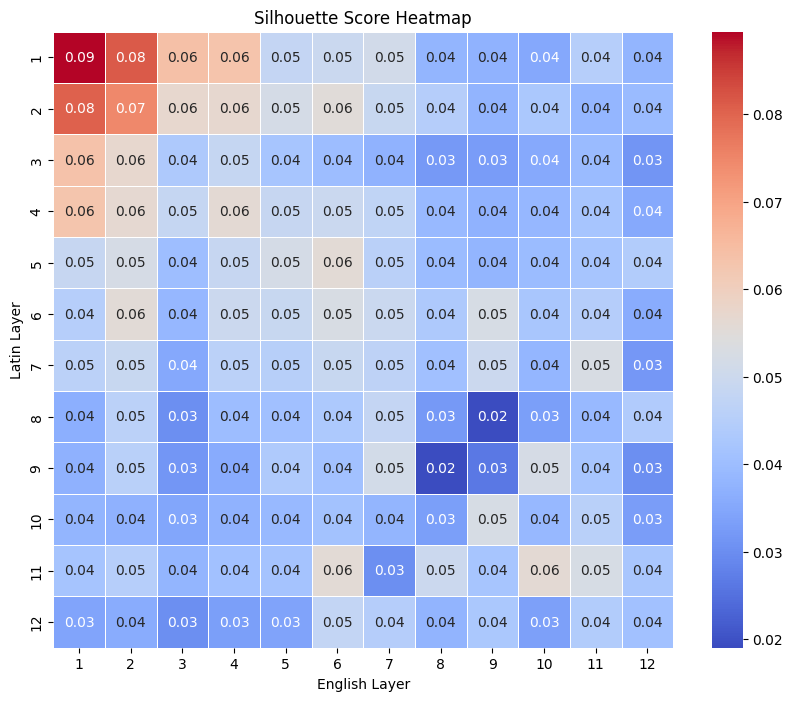

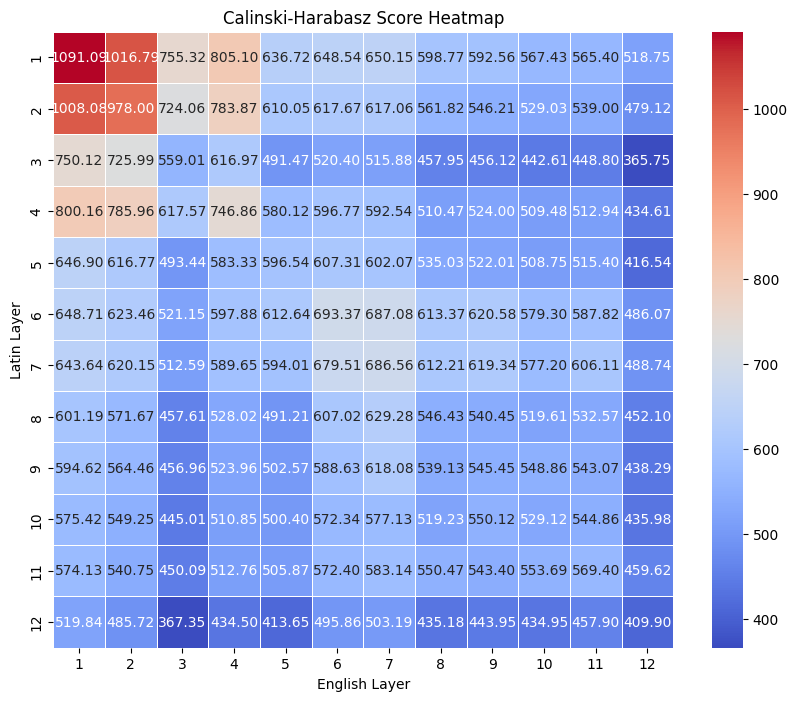

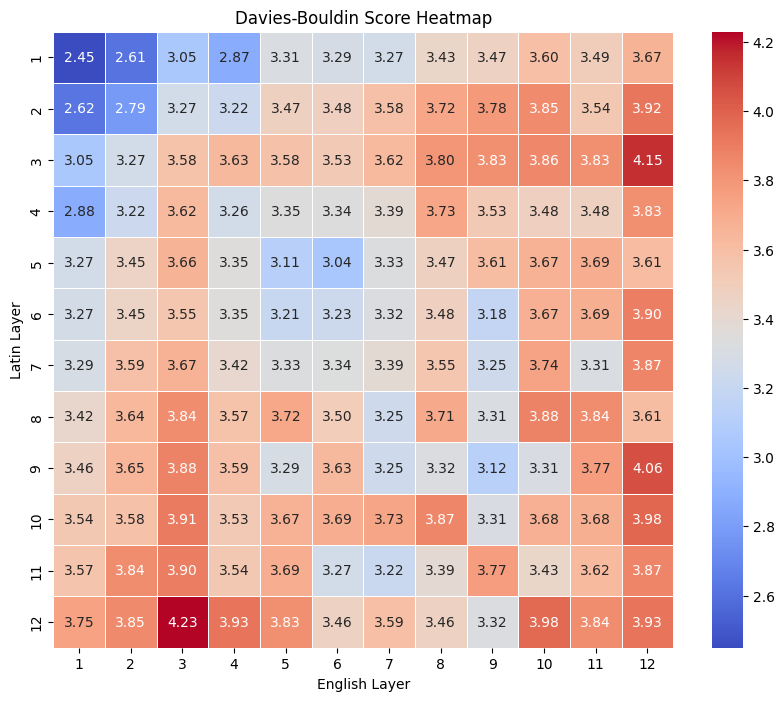

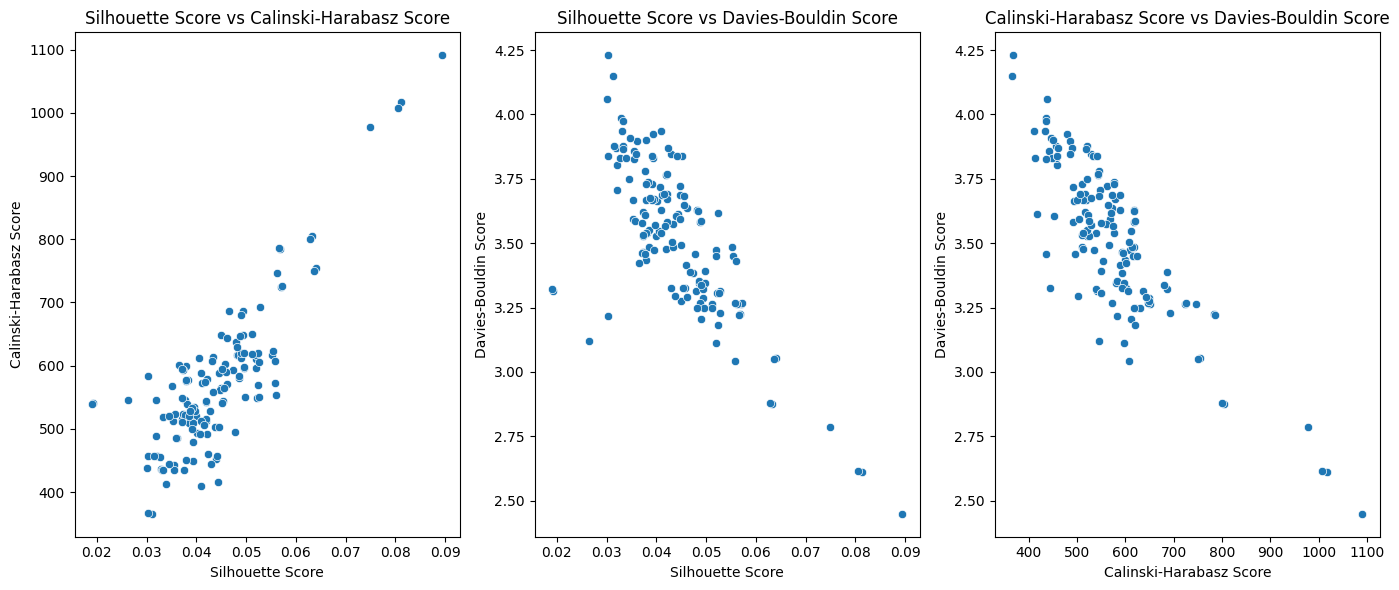

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# 读取结果数据
df = pd.read_csv("layer_combination_results_4topics.csv")

# 创建一个绘图函数
def plot_heatmap(data, value, title):
    pivot_table = data.pivot(index="Latin Layer", columns="English Layer", values=value)
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5)
    plt.title(title)
    plt.show()

# 绘制Silhouette Score的热力图
plot_heatmap(df, "Silhouette Score", "Silhouette Score Heatmap")

# 绘制Calinski-Harabasz Score的热力图
plot_heatmap(df, "Calinski-Harabasz Score", "Calinski-Harabasz Score Heatmap")

# 绘制Davies-Bouldin Score的热力图
plot_heatmap(df, "Davies-Bouldin Score", "Davies-Bouldin Score Heatmap")

# 创建散点图来展示不同评估指标之间的关系
plt.figure(figsize=(14, 6))

# Silhouette Score vs Calinski-Harabasz Score
plt.subplot(1, 3, 1)
sns.scatterplot(x='Silhouette Score', y='Calinski-Harabasz Score', data=df)
plt.title('Silhouette Score vs Calinski-Harabasz Score')

# Silhouette Score vs Davies-Bouldin Score
plt.subplot(1, 3, 2)
sns.scatterplot(x='Silhouette Score', y='Davies-Bouldin Score', data=df)
plt.title('Silhouette Score vs Davies-Bouldin Score')

# Calinski-Harabasz Score vs Davies-Bouldin Score
plt.subplot(1, 3, 3)
sns.scatterplot(x='Calinski-Harabasz Score', y='Davies-Bouldin Score', data=df)
plt.title('Calinski-Harabasz Score vs Davies-Bouldin Score')

plt.tight_layout()
plt.show()


Silhouette Score Asymmetric Pairs: [((1, 2), 0.08122401, 0.080524795), ((1, 3), 0.06398907, 0.06358373), ((1, 4), 0.06322599, 0.06278545), ((1, 5), 0.047980662, 0.04870643), ((1, 6), 0.049391188, 0.04491172), ((1, 7), 0.051196896, 0.046124537), ((1, 8), 0.037834566, 0.036487494), ((1, 9), 0.0373576, 0.037044123), ((1, 10), 0.035207245, 0.037939128), ((1, 11), 0.044998277, 0.04178628), ((1, 12), 0.037809774, 0.034419704), ((2, 1), 0.080524795, 0.08122401), ((2, 3), 0.057064723, 0.057234082), ((2, 4), 0.056797456, 0.056586053), ((2, 5), 0.051901326, 0.05204942), ((2, 6), 0.055141773, 0.055452794), ((2, 7), 0.048766937, 0.048980948), ((2, 8), 0.04474528, 0.046193965), ((2, 9), 0.03764066, 0.04554464), ((2, 10), 0.042846978, 0.037092578), ((2, 11), 0.038126737, 0.045115687), ((2, 12), 0.03929116, 0.035915196), ((3, 1), 0.06358373, 0.06398907), ((3, 2), 0.057234082, 0.057064723), ((3, 4), 0.04824308, 0.048452955), ((3, 5), 0.042049274, 0.040204793), ((3, 6), 0.03987713, 0.038519636), ((3, 7

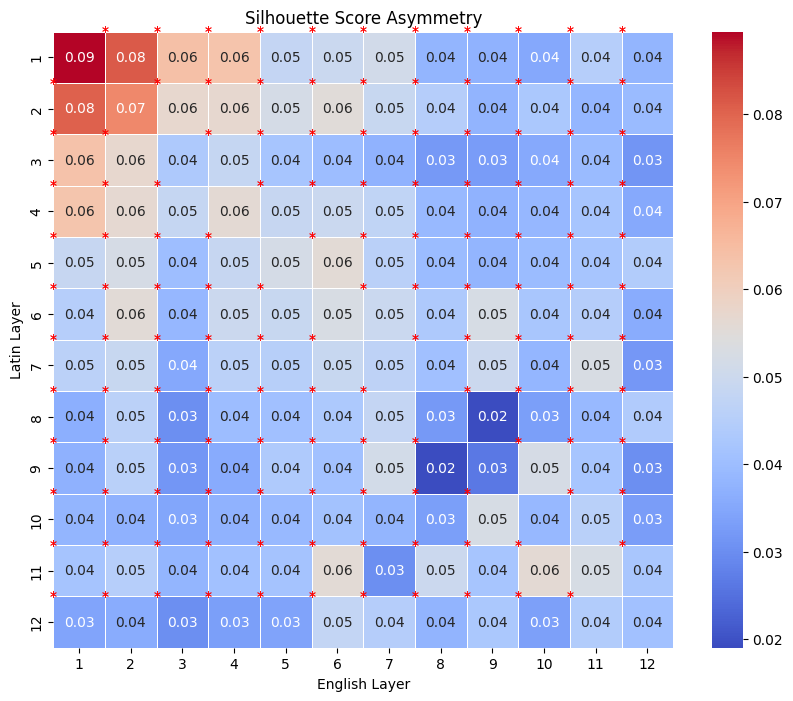

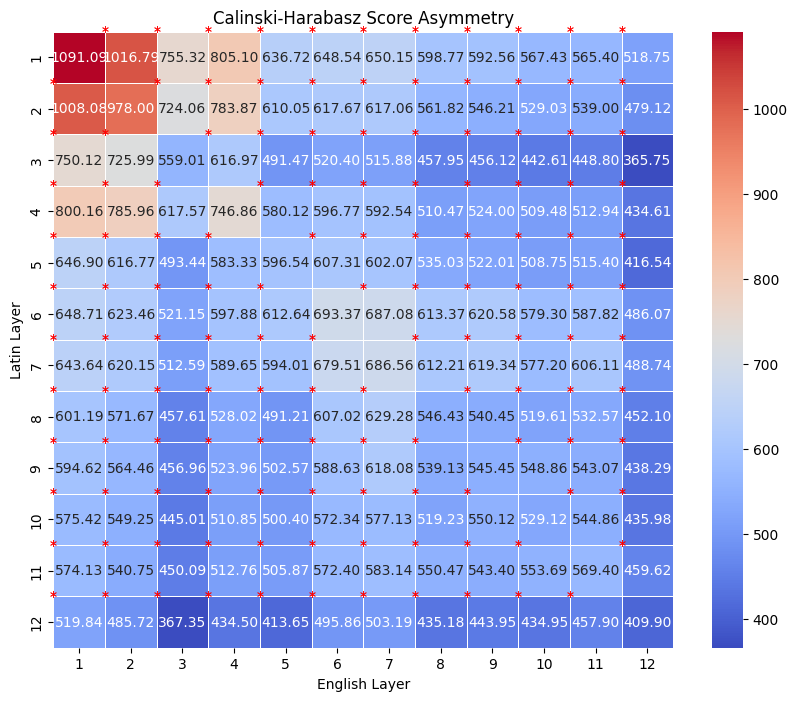

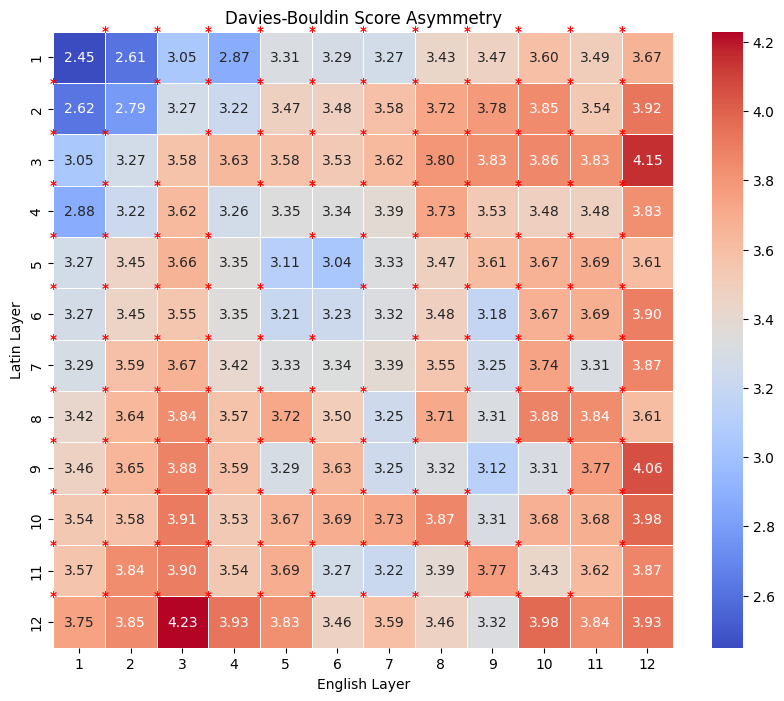

: 

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 读取结果数据
df = pd.read_csv("layer_combination_results_4topics.csv")

# 创建一个检查对称性的函数
def check_symmetry(data, value):
    pivot_table = data.pivot(index="Latin Layer", columns="English Layer", values=value)
    asym_pairs = []
    for i in range(1, 13):
        for j in range(1, 13):
            if pivot_table.loc[i, j] != pivot_table.loc[j, i]:
                asym_pairs.append(((i, j), pivot_table.loc[i, j], pivot_table.loc[j, i]))
    return asym_pairs

# 检查Silhouette Score的对称性
silhouette_asym_pairs = check_symmetry(df, "Silhouette Score")
print("Silhouette Score Asymmetric Pairs:", silhouette_asym_pairs)

# 检查Calinski-Harabasz Score的对称性
calinski_asym_pairs = check_symmetry(df, "Calinski-Harabasz Score")
print("Calinski-Harabasz Score Asymmetric Pairs:", calinski_asym_pairs)

# 检查Davies-Bouldin Score的对称性
davies_asym_pairs = check_symmetry(df, "Davies-Bouldin Score")
print("Davies-Bouldin Score Asymmetric Pairs:", davies_asym_pairs)

# 可视化不对称配对
def plot_asymmetry(data, asym_pairs, value, title):
    pivot_table = data.pivot(index="Latin Layer", columns="English Layer", values=value)
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5)
    for (i, j), val1, val2 in asym_pairs:
        plt.text(j-1, i-1, f"*", color='red', ha='center', va='center')
        plt.text(i-1, j-1, f"*", color='red', ha='center', va='center')
    plt.title(title)
    plt.show()

# 绘制Silhouette Score的不对称配对
plot_asymmetry(df, silhouette_asym_pairs, "Silhouette Score", "Silhouette Score Asymmetry")

# 绘制Calinski-Harabasz Score的不对称配对
plot_asymmetry(df, calinski_asym_pairs, "Calinski-Harabasz Score", "Calinski-Harabasz Score Asymmetry")

# 绘制Davies-Bouldin Score的不对称配对
plot_asymmetry(df, davies_asym_pairs, "Davies-Bouldin Score", "Davies-Bouldin Score Asymmetry")


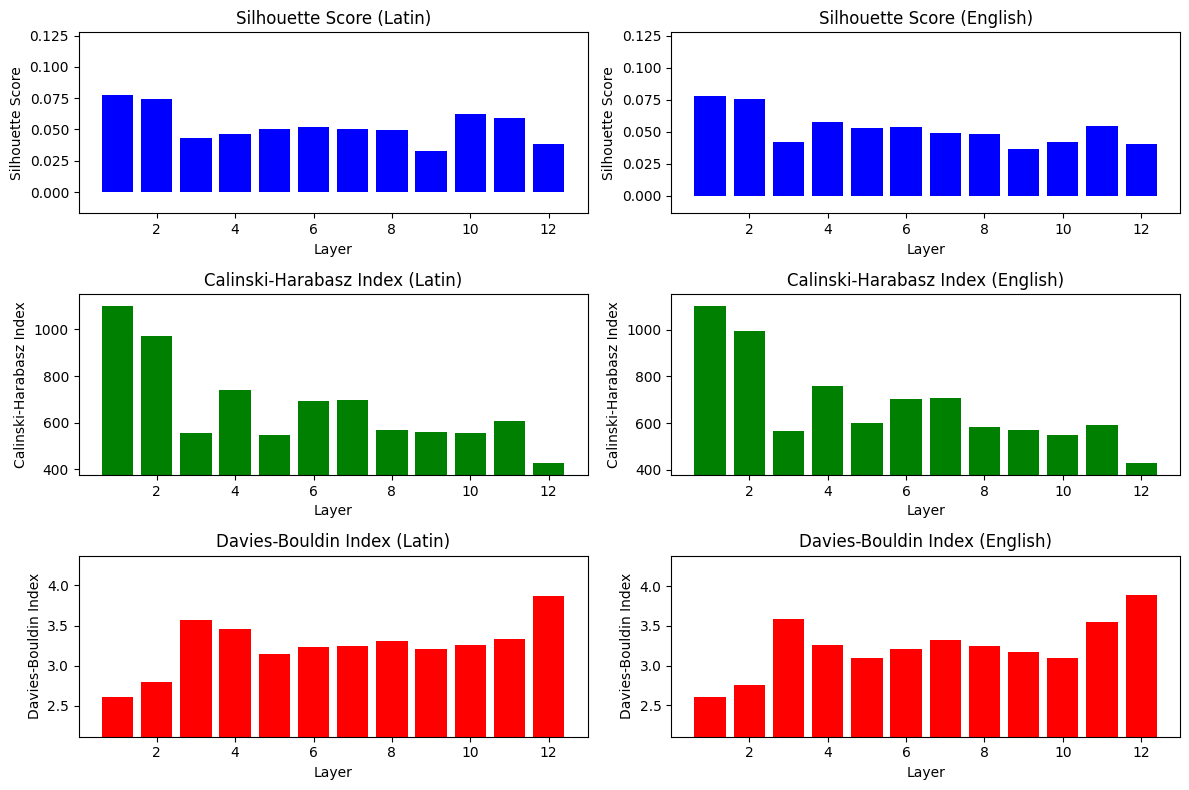

In [11]:
# 存储每层的评估指标
results = []
import numpy as np
# 评估每一层的特征向量
for layer in range(1, 13):
    latin_layer_features = np.array([features[layer-1] for features in latin_features])
    english_layer_features = np.array([features[layer-1] for features in english_features])
    
    # 评估拉丁层的聚类效果
    silhouette_avg, calinski_harabasz_avg, davies_bouldin_avg = evaluate_clustering(latin_layer_features)
    results.append(('latin', layer, silhouette_avg, calinski_harabasz_avg, davies_bouldin_avg))
    
    # 评估英文层的聚类效果
    silhouette_avg, calinski_harabasz_avg, davies_bouldin_avg = evaluate_clustering(english_layer_features)
    results.append(('english', layer, silhouette_avg, calinski_harabasz_avg, davies_bouldin_avg))

# 可视化结果
layers = [r[1] for r in results if r[0] == 'latin']
latin_silhouette_scores = [r[2] for r in results if r[0] == 'latin']
latin_calinski_harabasz_scores = [r[3] for r in results if r[0] == 'latin']
latin_davies_bouldin_scores = [r[4] for r in results if r[0] == 'latin']

english_silhouette_scores = [r[2] for r in results if r[0] == 'english']
english_calinski_harabasz_scores = [r[3] for r in results if r[0] == 'english']
english_davies_bouldin_scores = [r[4] for r in results if r[0] == 'english']

plt.figure(figsize=(12, 8))

plt.subplot(3, 2, 1)
plt.bar(layers, latin_silhouette_scores, color='blue')

# 导出实验数据
experiment_data = {
    "layers": layers,
    "latin_silhouette_scores": [float(score) for score in latin_silhouette_scores],
    "latin_calinski_harabasz_scores": [float(score) for score in latin_calinski_harabasz_scores],
    "latin_davies_bouldin_scores": [float(score) for score in latin_davies_bouldin_scores],
    "english_silhouette_scores": [float(score) for score in english_silhouette_scores],
    "english_calinski_harabasz_scores": [float(score) for score in english_calinski_harabasz_scores],
    "english_davies_bouldin_scores": [float(score) for score in english_davies_bouldin_scores]
}

with open("experiment_data.json", "w") as f:
    json.dump(experiment_data, f, indent=4)
plt.title('Silhouette Score (Latin)')
plt.xlabel('Layer')
plt.ylabel('Silhouette Score')
plt.ylim(min(latin_silhouette_scores) - 0.05, max(latin_silhouette_scores) + 0.05)

plt.subplot(3, 2, 2)
plt.bar(layers, english_silhouette_scores, color='blue')
plt.title('Silhouette Score (English)')
plt.xlabel('Layer')
plt.ylabel('Silhouette Score')
plt.ylim(min(english_silhouette_scores) - 0.05, max(english_silhouette_scores) + 0.05)

plt.subplot(3, 2, 3)
plt.bar(layers, latin_calinski_harabasz_scores, color='green')
plt.title('Calinski-Harabasz Index (Latin)')
plt.xlabel('Layer')
plt.ylabel('Calinski-Harabasz Index')
plt.ylim(min(latin_calinski_harabasz_scores) - 50, max(latin_calinski_harabasz_scores) + 50)

plt.subplot(3, 2, 4)
plt.bar(layers, english_calinski_harabasz_scores, color='green')
plt.title('Calinski-Harabasz Index (English)')
plt.xlabel('Layer')
plt.ylabel('Calinski-Harabasz Index')
plt.ylim(min(english_calinski_harabasz_scores) - 50, max(english_calinski_harabasz_scores) + 50)

plt.subplot(3, 2, 5)
plt.bar(layers, latin_davies_bouldin_scores, color='red')
plt.title('Davies-Bouldin Index (Latin)')
plt.xlabel('Layer')
plt.ylabel('Davies-Bouldin Index')
plt.ylim(min(latin_davies_bouldin_scores) - 0.5, max(latin_davies_bouldin_scores) + 0.5)

plt.subplot(3, 2, 6)
plt.bar(layers, english_davies_bouldin_scores, color='red')
plt.title('Davies-Bouldin Index (English)')
plt.xlabel('Layer')
plt.ylabel('Davies-Bouldin Index')
plt.ylim(min(english_davies_bouldin_scores) - 0.5, max(english_davies_bouldin_scores) + 0.5)

plt.tight_layout()
plt.show()


Eng12-Latin11
Silhouette Score: 0.09 最好（越靠近1越好）
Calinski-Harabasz Index: 970.76
Davies-Bouldin Index: 2.60 最好 (越小越好)

Eng12-Latin12
Silhouette Score: 0.089
Calinski-Harabasz Index: 1076.4 最好（越大越好）
Davies-Bouldin Index: 2.61

Eng11-Latin12
Silhouette Score: 0.081
Calinski-Harabasz Index: 927.0
Davies-Bouldin Index: 2.72

Silhouette Score（轮廓系数）:
定义: 轮廓系数衡量单个数据点与其所属聚类的紧密程度，以及与最近的其它聚类的分离程度。其值在-1到1之间。
解释:
值接近1：表示数据点与其所属聚类非常相似，并且远离其他聚类，聚类效果好。
值接近0：表示数据点位于两个聚类的边界上，聚类效果中等。
值接近-1：表示数据点更接近其他聚类，聚类效果差。

Calinski-Harabasz Index（CH 指数）:
定义: CH 指数也称为方差比标准（Variance Ratio Criterion，VRC）
它是簇间离差平方和（BSS）与簇内离差平方和（WSS）之比，调整后的样本数和簇数。
解释: CH 指数越大，表示聚类效果越好，簇间距离大而簇内距离小。

Davies-Bouldin Index（DB 指数）:
定义: DB 指数衡量聚类之间的相似度，其值为簇间距离与簇内距离之比的平均值。值越小，表示聚类效果越好。
解释: DB 指数越小，表示聚类效果越好，簇间距离大而簇内距离小。